In [1]:
!pip install numpy pandas

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Read data
taxi = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv',
                   index_col=0)

In [4]:
taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [5]:
taxi.index

Index(['2014-07-01 00:00:00', '2014-07-01 00:30:00', '2014-07-01 01:00:00',
       '2014-07-01 01:30:00', '2014-07-01 02:00:00', '2014-07-01 02:30:00',
       '2014-07-01 03:00:00', '2014-07-01 03:30:00', '2014-07-01 04:00:00',
       '2014-07-01 04:30:00',
       ...
       '2015-01-31 19:00:00', '2015-01-31 19:30:00', '2015-01-31 20:00:00',
       '2015-01-31 20:30:00', '2015-01-31 21:00:00', '2015-01-31 21:30:00',
       '2015-01-31 22:00:00', '2015-01-31 22:30:00', '2015-01-31 23:00:00',
       '2015-01-31 23:30:00'],
      dtype='object', name='timestamp', length=10320)

In [6]:
taxi.index = pd.to_datetime(taxi.index)
taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [7]:
data = taxi['value'].astype(float).values
data

array([10844.,  8127.,  6210., ..., 27309., 26591., 26288.])

In [8]:
# Create events
events = {
'independence_day' : ('2014-07-04 00:00:00',
                      '2014-07-07 00:00:00'),
'labor_day'        : ('2014-09-01 00:00:00',
                      '2014-09-02 00:00:00'),
'labor_day_parade' : ('2014-09-06 00:00:00',
                      '2014-09-07 00:00:00'),
'nyc_marathon'     : ('2014-11-02 00:00:00',
                      '2014-11-03 00:00:00'),
'thanksgiving'     : ('2014-11-27 00:00:00',
                      '2014-11-28 00:00:00'),
'christmas'        : ('2014-12-25 00:00:00',
                      '2014-12-26 00:00:00'),
'new_year'         : ('2015-01-01 00:00:00',
                      '2015-01-02 00:00:00'),
'blizzard'         : ('2015-01-26 00:00:00',
                      '2015-01-28 00:00:00')
}
taxi['event'] = np.zeros(len(taxi))
for event, duration in events.items():
    start, end = duration
    taxi.loc[start:end, 'event'] = 1

In [9]:
# Set tree parameters
num_trees = 200
shingle_size = 48
tree_size = 1000

In [10]:
import rrcf
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(data, size=shingle_size)
points = np.vstack([point for point in points])

# Running Isolation Forest

[sklearn.ensemble.IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [11]:
contamination = taxi['event'].sum()/len(taxi)

In [12]:
contamination

0.05193798449612403

In [13]:
IF = IsolationForest(n_estimators=num_trees,
                     contamination=contamination,
                     random_state=0)

In [14]:
# IF = IsolationForest(n_estimators=num_trees,
#                     contamination=contamination,
#                     behaviour='new',
#                     random_state=0)

In [15]:
IF.fit(points)
if_scores = IF.score_samples(points)
if_scores = pd.Series(-if_scores,
                      index=(taxi
                             .iloc[(shingle_size - 1):]
                             .index))

# Plotting the results

<AxesSubplot:xlabel='timestamp'>

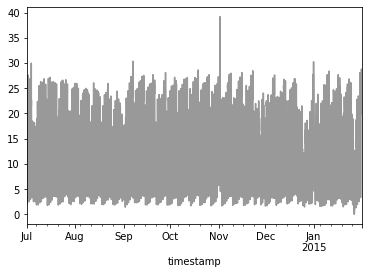

In [17]:
(taxi['value'] / 1000).plot(color='0.5',
                            alpha=0.8)

<AxesSubplot:xlabel='timestamp'>

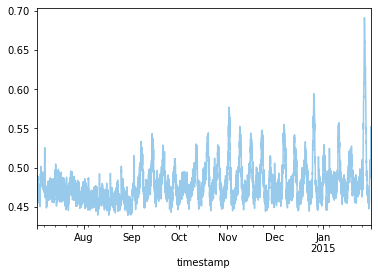

In [16]:
if_scores.plot(color='#7EBDE6', alpha=0.8,
               label='IF')

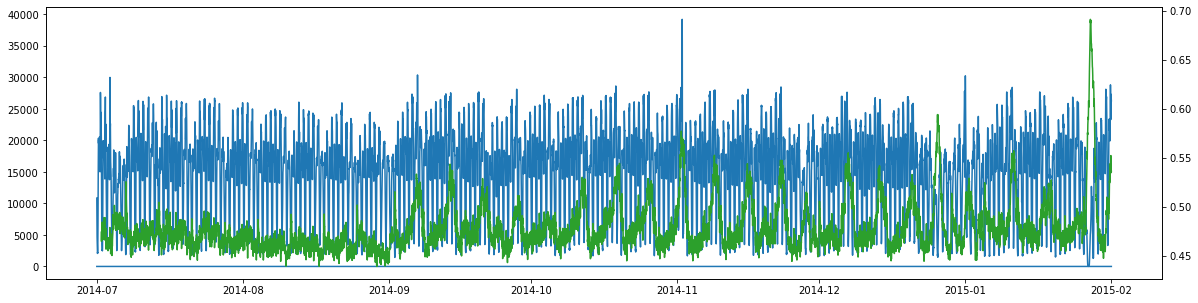

In [21]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(taxi, color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(pd.Series(if_scores).sort_index(), color='tab:green')